In [ ]:
!pip install sentence-transformers

In [ ]:
import re
from typing import Any
import json
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
def schema_discovery(json_list):
    """
    Processes a list of policy JSON objects to discover action schema.
    Extracts action strings from the top-level 'actions' list (each action is
    an object with an 'action' field), generates Sentence-BERT embeddings,
    clusters them, derives a canonical variable, and adds it back to the policy.

    Policies with discovery.human_validated == false are skipped entirely.

    Args:
        json_list (list): A list of policy JSON objects using the v1.0 schema.

    Returns:
        list: The modified list with 'canonical_action' added to qualifying policies.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')

    processed_json_list = json.loads(json.dumps(json_list))

    # --- Filter out policies where discovery.human_validated is false ---
    eligible_indices = []
    for i, obj in enumerate(processed_json_list):
        if not isinstance(obj, dict):
            print(f"Warning: Object {i} is not a dictionary. Skipping.")
            continue

        discovery = obj.get("discovery")
        if isinstance(discovery, dict) and discovery.get("human_validated") is False:
            print(f"Skipping policy {obj.get('policy_id', i)}: "
                  f"discovery.human_validated is false.")
            continue

        eligible_indices.append(i)

    # --- Extract action strings from eligible policies ---
    all_actions = []
    action_to_obj_map = []

    for i in eligible_indices:
        obj = processed_json_list[i]
        actions_field = obj.get("actions")

        if not isinstance(actions_field, list):
            print(f"Warning: 'actions' field in policy {obj.get('policy_id', i)} "
                  f"is not a list or missing. Skipping.")
            continue

        for action_obj in actions_field:
            # Each action is an object like {"type": "required", "action": "full_refund", ...}
            if isinstance(action_obj, dict):
                action_str = action_obj.get("action")
            elif isinstance(action_obj, str):
                # Fallback: accept plain strings for backward compat
                action_str = action_obj
            else:
                action_str = None

            if action_str:
                all_actions.append(action_str)
                action_to_obj_map.append({"obj_index": i, "action": action_str})

    if not all_actions:
        print("No actions found to process.")
        return processed_json_list

    # --- Generate embeddings and cluster ---
    action_embeddings = model.encode(all_actions, convert_to_tensor=True)

    clusters = []
    action_clustered = [False] * len(all_actions)
    cosine_threshold = 0.7

    for i, emb_i in enumerate(action_embeddings):
        if action_clustered[i]:
            continue

        current_cluster = [all_actions[i]]
        action_clustered[i] = True
        cluster_mappings = [action_to_obj_map[i]]

        for j, emb_j in enumerate(action_embeddings):
            if i == j or action_clustered[j]:
                continue

            cosine_score = util.cos_sim(emb_i, emb_j)
            if cosine_score > cosine_threshold:
                current_cluster.append(all_actions[j])
                action_clustered[j] = True
                cluster_mappings.append(action_to_obj_map[j])

        clusters.append({"actions": current_cluster, "mappings": cluster_mappings})

    # --- Keep only cross-policy clusters (span >= 2 distinct policies) ---
    cross_policy_clusters = []
    for cluster in clusters:
        unique_obj_indices = {m["obj_index"] for m in cluster["mappings"]}
        if len(unique_obj_indices) >= 2:
            cross_policy_clusters.append(cluster)

    clusters = cross_policy_clusters

    # --- Derive canonical_action and write back ---
    for cluster in clusters:
        canonical_var = cluster["actions"][0]

        for mapping in cluster["mappings"]:
            obj_index = mapping["obj_index"]
            policy = processed_json_list[obj_index]
            if "canonical_actions" not in policy:
                policy["canonical_actions"] = []
            if canonical_var not in policy["canonical_actions"]:
                policy["canonical_actions"].append(canonical_var)

    return processed_json_list


# ──────────────────────────────────────────────
# Demo with the new schema
# ──────────────────────────────────────────────

example_policies = [
    {
        "schema_version": "1.0",
        "processing_status": {
            "extraction": "complete",
            "formalization": "pending",
            "conflict_detection": "pending",
            "layer_assignment": "pending"
        },
        "policy_id": "POL-REFUND-001",
        "origin": "explicit",
        "scope": {
            "customer_segments": ["all"],
            "product_categories": ["all"],
            "channels": ["online", "in-store"],
            "regions": ["all"]
        },
        "conditions": [
            {
                "type": "time_window",
                "value": 30,
                "unit": "days",
                "operator": "<=",
                "target": "general",
                "source_text": "Customers may return items within 30 days of purchase"
            }
        ],
        "actions": [
            {
                "type": "required",
                "action": "full_refund",
                "requires": ["has_receipt", "within_window"],
                "source_text": "Customers may return items within 30 days of purchase for a full refund"
            },
            {
                "type": "fallback",
                "action": "store_credit",
                "requires": ["no_receipt"],
                "source_text": "Items without receipt receive store credit only"
            }
        ],
        "exceptions": [],
        "metadata": {
            "source": "return_policy_v3.2, §4.1",
            "owner": "Customer Service Dept.",
            "effective_date": "2024-01-15",
            "domain": "refund",
            "regulatory_linkage": ["FTC Cooling-Off Rule"]
        }
    },
    {
        "schema_version": "1.0",
        "processing_status": {
            "extraction": "complete",
            "formalization": "pending",
            "conflict_detection": "pending",
            "layer_assignment": "pending"
        },
        "policy_id": "POL-REFUND-002",
        "origin": "explicit",
        "scope": {
            "customer_segments": ["all"],
            "product_categories": ["electronics"],
            "channels": ["online"],
            "regions": ["all"]
        },
        "conditions": [
            {
                "type": "time_window",
                "value": 15,
                "unit": "days",
                "operator": "<=",
                "target": "electronics",
                "source_text": "Electronics must be returned within 15 days"
            }
        ],
        "actions": [
            {
                "type": "required",
                "action": "complete_refund",
                "requires": ["has_receipt", "within_window"],
                "source_text": "Electronics returned within 15 days receive a complete refund"
            },
            {
                "type": "fallback",
                "action": "store_credit_only",
                "requires": ["no_receipt"],
                "source_text": "Without receipt, store credit is issued"
            }
        ],
        "exceptions": [],
        "metadata": {
            "source": "return_policy_v3.2, §4.2",
            "owner": "Customer Service Dept.",
            "effective_date": "2024-01-15",
            "domain": "refund",
            "regulatory_linkage": []
        }
    },
    {
        "schema_version": "1.0",
        "processing_status": {
            "extraction": "complete",
            "formalization": "pending",
            "conflict_detection": "pending",
            "layer_assignment": "pending"
        },
        "policy_id": "POL-IMP-REFUND-003",
        "origin": "implicit",
        "discovery": {
            "confidence": 0.87,
            "support": 124,
            "source_log": "cs_tickets_2024Q1.csv",
            "human_validated": False
        },
        "scope": {
            "customer_segments": ["VIP"],
            "product_categories": ["all"],
            "channels": ["all"],
            "regions": ["all"]
        },
        "conditions": [
            {
                "type": "amount_threshold",
                "value": 200,
                "unit": "USD",
                "operator": ">",
                "target": "VIP",
                "source_text": None
            }
        ],
        "actions": [
            {
                "type": "discovered_pattern",
                "action": "auto_approve_refund",
                "requires": ["VIP_status", "amount_over_200"],
                "source_text": None
            }
        ],
        "exceptions": [],
        "metadata": {
            "source": "cs_tickets_2024Q1.csv (mined)",
            "owner": "TBD",
            "effective_date": None,
            "domain": "refund",
            "regulatory_linkage": []
        }
    }
]

processed = schema_discovery(example_policies)
print("\nProcessed Policies:")
for p in processed:
    print(json.dumps(p, indent=2))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Skipping policy POL-IMP-REFUND-003: discovery.human_validated is false.

Processed Policies:
{
  "schema_version": "1.0",
  "processing_status": {
    "extraction": "complete",
    "formalization": "pending",
    "conflict_detection": "pending",
    "layer_assignment": "pending"
  },
  "policy_id": "POL-REFUND-001",
  "origin": "explicit",
  "scope": {
    "customer_segments": [
      "all"
    ],
    "product_categories": [
      "all"
    ],
    "channels": [
      "online",
      "in-store"
    ],
    "regions": [
      "all"
    ]
  },
  "conditions": [
    {
      "type": "time_window",
      "value": 30,
      "unit": "days",
      "operator": "<=",
      "target": "general",
      "source_text": "Customers may return items within 30 days of purchase"
    }
  ],
  "actions": [
    {
      "type": "required",
      "action": "full_refund",
      "requires": [
        "has_receipt",
        "within_window"
      ],
      "source_text": "Customers may return items within 30 days of 

In [ ]:
_model = None
_tokenizer = None


def _load_model():
    global _model, _tokenizer
    if _model is not None:
        return _model, _tokenizer

    from transformers import AutoModelForCausalLM, AutoTokenizer

    model_name = "Qwen/Qwen3-4B"
    print(f"[policy_to_pseudocode] Loading {model_name} …")
    _tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    _model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype="auto",
        device_map="auto",
        trust_remote_code=True,
    )
    print("[policy_to_pseudocode] Model loaded.")
    return _model, _tokenizer


# ---------------------------------------------------------------------------
# Prompt construction
# ---------------------------------------------------------------------------

SYSTEM_PROMPT = """\
You are a policy-to-pseudocode converter. You receive structured policy fields \
and return ONLY a JSON array of pseudocode instruction strings. No explanation, \
no commentary, no markdown fences, no thinking out loud.

FORMAT RULES — follow exactly:
• Output must start with [ and end with ].
• Each element is a quoted string containing one pseudocode instruction.
• Use IF/THEN/ELSE, FOR EACH, SET, EXECUTE, and plain directives.
• If "canonical_actions" is provided, use those names as variable/action names \
  instead of the raw action names from "actions".
• Cover ALL scope constraints, conditions, actions, and exceptions.
• If exceptions is empty, include one instruction: "NO EXCEPTIONS DEFINED".

EXAMPLE INPUT:
scope: {"customer_segments":["premium"],"product_categories":["books"],"channels":["online"],"regions":["US"]}
conditions: [{"type":"time_window","value":7,"operator":"<=","target":"books"}]
actions: [{"name":"refund_action","type":"required","requires":["has_receipt","within_window"]}]
exceptions: []
canonical_actions: ["issue_refund"]

EXAMPLE OUTPUT:
["SET policy_scope TO customer_segment='premium' AND product_category='books' AND channel='online' AND region='US'","IF return_date <= purchase_date + 7 days THEN SET within_window TO TRUE","IF has_receipt AND within_window THEN EXECUTE issue_refund","NO EXCEPTIONS DEFINED"]

Now produce output for the policy below. Output ONLY the JSON array.\
"""


def _build_user_prompt(policy_fields: dict) -> str:
    """Format the extracted policy fields into the user message."""
    parts = []
    for key in ("scope", "conditions", "actions", "exceptions", "canonical_actions"):
        value = policy_fields.get(key)
        if value is not None:
            parts.append(f"{key}: {json.dumps(value)}")
    return "\n".join(parts)


# ---------------------------------------------------------------------------
# Generation & parsing
# ---------------------------------------------------------------------------

MAX_RETRIES = 3


def _generate(user_prompt: str, max_new_tokens: int = 1024) -> str:
    """Send a single chat-style request to Qwen3-4B and return the reply."""
    model, tokenizer = _load_model()

    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_prompt},
    ]

    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    # Qwen3 supports /no_think to suppress chain-of-thought.  Append it to
    # the generation prompt so the model skips its <think> block entirely.
    if not text.rstrip().endswith("/no_think"):
        text = text.rstrip() + " /no_think\n"

    inputs = tokenizer([text], return_tensors="pt").to(model.device)

    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.3,        # low temperature for deterministic JSON
        top_p=0.9,
        do_sample=True,
    )

    generated_ids = output_ids[0][inputs["input_ids"].shape[-1] :]
    return tokenizer.decode(generated_ids, skip_special_tokens=True).strip()


def _strip_thinking(text: str) -> str:
    """
    Remove any <think>…</think> blocks that Qwen3 may emit despite /no_think.
    Also strips orphan <think> tags with no closing tag (model ran out of
    tokens mid-thought).
    """
    # Paired blocks
    text = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
    # Orphan opening tag — everything from <think> to end is thinking
    text = re.sub(r"<think>.*", "", text, flags=re.DOTALL)
    return text.strip()


def _parse_json_array(text: str) -> list[str] | None:
    """
    Try to extract a JSON string array from the model's raw output.
    Returns None on failure (so the caller can retry).
    """
    # 1. Strip thinking blocks
    text = _strip_thinking(text)

    # 2. Remove markdown code fences
    text = re.sub(r"```(?:json)?\s*", "", text)
    text = re.sub(r"```", "", text)
    text = text.strip()

    # 3. Find the outermost [...] bracket pair with proper nesting
    start = text.find("[")
    if start == -1:
        return None

    depth = 0
    end = None
    in_string = False
    escape_next = False
    for i in range(start, len(text)):
        ch = text[i]
        if escape_next:
            escape_next = False
            continue
        if ch == "\\":
            escape_next = True
            continue
        if ch == '"':
            in_string = not in_string
            continue
        if in_string:
            continue
        if ch == "[":
            depth += 1
        elif ch == "]":
            depth -= 1
            if depth == 0:
                end = i
                break

    if end is None:
        return None

    candidate = text[start : end + 1]

    # 4. Fixups for common LLM quirks
    candidate = re.sub(r",\s*]", "]", candidate)          # trailing commas
    candidate = candidate.replace("\u2018", '"').replace("\u2019", '"')  # smart quotes
    candidate = candidate.replace("\u201c", '"').replace("\u201d", '"')
    candidate = re.sub(r'"\s*\n\s*"', '", "', candidate)  # missing commas

    try:
        parsed = json.loads(candidate)
    except json.JSONDecodeError:
        return None

    if not isinstance(parsed, list):
        return None

    # 5. Validate: every element must be a non-empty string, filter junk
    JUNK_PREFIXES = (
        "<think", "okay,", "let me", "first,", "starting with",
        "next,", "now,", "wait,", "hmm", "so,", "putting it",
        "alternatively", "i need", "the user",
    )
    result = []
    for item in parsed:
        s = str(item).strip()
        if not s:
            continue
        if s.lower().startswith(JUNK_PREFIXES):
            continue
        if len(s) > 500:       # likely leaked prose, not an instruction
            continue
        result.append(s)

    return result if result else None


def _validate_pseudocode(instructions: list[str]) -> bool:
    """
    Basic sanity checks on the parsed pseudocode list.
    Returns True if the output looks like real pseudocode.
    """
    if not instructions or len(instructions) < 1:
        return False

    # At least one instruction should contain a pseudocode keyword
    keywords = (
        "IF", "THEN", "ELSE", "SET", "FOR", "EXECUTE", "APPLY",
        "WHEN", "CHECK", "RETURN", "NO EXCEPTIONS", "EXCEPTION",
    )
    has_keyword = any(
        any(kw in instr.upper() for kw in keywords)
        for instr in instructions
    )
    return has_keyword

EXTRACT_KEYS = ("scope", "conditions", "actions", "exceptions", "canonical_actions")


def policy_to_pseudocode(policy: dict[str, Any]) -> list[str]:
    """
    Convert a single policy dict into a list of pseudocode instruction strings
    using Qwen3-4B.

    Includes a retry loop: if the model output fails parsing or validation,
    the call is retried up to MAX_RETRIES times.

    Parameters
    ----------
    policy : dict
        A policy object that should contain some/all of the keys:
        scope, conditions, actions, exceptions, canonical_actions.

    Returns
    -------
    list[str]
        Pseudocode instructions faithfully representing the policy's logic.
    """
    fields = {k: policy[k] for k in EXTRACT_KEYS if k in policy}
    if not fields:
        return []

    user_prompt = _build_user_prompt(fields)

    for attempt in range(1, MAX_RETRIES + 1):
        raw_output = _generate(user_prompt)
        parsed = _parse_json_array(raw_output)
        if parsed is not None and _validate_pseudocode(parsed):
            return parsed
        print(
            f"  [attempt {attempt}/{MAX_RETRIES}] Invalid output, "
            f"retrying… (got {len(raw_output)} chars)"
        )

    # All retries exhausted
    print("  [WARNING] All retries exhausted — returning empty pseudocode list.")
    return []


def policies_to_pseudocode(
    policies: list[dict[str, Any]],
) -> list[dict[str, Any]]:
    """
    Process a list of policy dicts, returning a list of result dicts that
    each contain the original policy (or an identifier) and the generated
    pseudocode instructions.

    Parameters
    ----------
    policies : list[dict]
        A JSON-deserialised list of policy objects.

    Returns
    -------
    list[dict]
        Each element has the shape::

            {
                "policy_id": <str or index>,
                "pseudocode": [<str>, ...]
            }
    """
    results = []
    for idx, policy in enumerate(policies):
        policy_id = policy.get("id") or policy.get("name") or str(idx)
        print(f"[{idx + 1}/{len(policies)}] Processing policy: {policy_id}")
        pseudocode = policy_to_pseudocode(policy)
        results.append({"policy_id": policy_id, "pseudocode": pseudocode})
    return results

In [ ]:
print(policies_to_pseudocode(processed))

[1/3] Processing policy: 0
[policy_to_pseudocode] Loading Qwen/Qwen3-4B …


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

[policy_to_pseudocode] Model loaded.
[2/3] Processing policy: 1
[3/3] Processing policy: 2
[{'policy_id': '0', 'pseudocode': ["SET policy_scope TO customer_segment='all' AND product_category='all' AND channel='online' OR channel='in-store' AND region='all'", 'IF return_date <= purchase_date + 30 days THEN SET within_window TO TRUE', 'IF has_receipt AND within_window THEN EXECUTE full_refund', 'IF no_receipt THEN EXECUTE store_credit', 'NO EXCEPTIONS DEFINED']}, {'policy_id': '1', 'pseudocode': ["SET policy_scope TO customer_segment='all' AND product_category='electronics' AND channel='online' AND region='all'", 'IF return_date <= purchase_date + 15 days THEN SET within_window TO TRUE', 'IF has_receipt AND within_window THEN EXECUTE full_refund', 'IF no_receipt THEN EXECUTE store_credit', 'NO EXCEPTIONS DEFINED']}, {'policy_id': '2', 'pseudocode': ["SET policy_scope TO customer_segment='VIP' AND product_category='all' AND channel='all' AND region='all'", 'IF transaction_amount > 200 USD

#Goutham's Implementation

###Todo: Implement Parser between Carlos's output to Goutham's Input

In [ ]:
import json
from datetime import date

# dummy data

policy_ir = {

    "variables": {
        "has_receipt": {
            "type": "bool",
            "description": "Customer has a valid purchase receipt"
        },
        "product_category": {
            "type": "enum",
            "values": ["electronics", "other"],
            "description": "Normalized product category"
        },
        "days_since_purchase": {
            "type": "int",
            "description": "Number of days since purchase date"
        },
        "refund_amount": {
            "type": "float",
            "description": "Refund amount requested in USD"
        },
        "customer_tier": {
            "type": "enum",
            "values": ["VIP", "standard"],
            "description": "Customer membership tier"
        }
    },

    "conditional_rules": [

        {
            "policy_id": "P0_GENERAL_RETURN",
            "conditions": [
                {"var": "has_receipt", "op": "==", "value": True},
                {"var": "days_since_purchase", "op": "<=", "value": 30},
                {"var": "product_category", "op": "!=", "value": "electronics"}
            ],
            "action": {
                "type": "refund",
                "value": "full"
            },
            "metadata": {
                "domain": "returns",
                "priority": "company",
                "owner": "customer_support",
                "source": "returns_policy_v3",
                "eff_date": "2024-01-01"
            }
        },

        {
            "policy_id": "P1_ELECTRONICS_RETURN",
            "conditions": [
                {"var": "has_receipt", "op": "==", "value": True},
                {"var": "product_category", "op": "==", "value": "electronics"},
                {"var": "days_since_purchase", "op": "<=", "value": 15}
            ],
            "action": {
                "type": "refund",
                "value": "full"
            },
            "metadata": {
                "domain": "returns",
                "priority": "company",
                "owner": "customer_support",
                "source": "electronics_policy_v2",
                "eff_date": "2024-01-01"
            }
        },

        {
            "policy_id": "P2_VIP_HIGH_VALUE",
            "conditions": [
                {"var": "customer_tier", "op": "==", "value": "VIP"},
                {"var": "refund_amount", "op": ">", "value": 200}
            ],
            "action": {
                "type": "approval",
                "value": "auto"
            },
            "metadata": {
                "domain": "returns",
                "priority": "company",
                "owner": "loyalty_team",
                "source": "vip_refund_guidelines",
                "eff_date": "2023-06-01"
            }
        }
    ],

    "constraints": [
        {
            "policy_id": "C0_NO_PREMATURE_COMMITMENT",
            "constraint": "NOT(promise_refund_before_eligibility_verified)",
            "scope": "always",
            "metadata": {
                "domain": "communication",
                "priority": "company",
                "owner": "legal",
                "source": "customer_communication_policy",
                "eff_date": "2024-01-01"
            }
        }
    ],

    "ir_metadata": {
        "generated_on": str(date.today()),
        "generator": "PolicyLLM-2C-Normalizer-v1",
        "upstream_model": "Qwen/Qwen3-4B",
        "notes": "Derived from LLM-generated pseudocode via deterministic normalization"
    }
}

print(json.dumps(policy_ir, indent=2))


{
  "variables": {
    "has_receipt": {
      "type": "bool",
      "description": "Customer has a valid purchase receipt"
    },
    "product_category": {
      "type": "enum",
      "values": [
        "electronics",
        "other"
      ],
      "description": "Normalized product category"
    },
    "days_since_purchase": {
      "type": "int",
      "description": "Number of days since purchase date"
    },
    "refund_amount": {
      "type": "float",
      "description": "Refund amount requested in USD"
    },
    "customer_tier": {
      "type": "enum",
      "values": [
        "VIP",
        "standard"
      ],
      "description": "Customer membership tier"
    }
  },
  "conditional_rules": [
    {
      "policy_id": "P0_GENERAL_RETURN",
      "conditions": [
        {
          "var": "has_receipt",
          "op": "==",
          "value": true
        },
        {
          "var": "days_since_purchase",
          "op": "<=",
          "value": 30
        },
        {
    

In [ ]:
import json
from dataclasses import dataclass
from collections import Counter, defaultdict
from typing import Any, Dict, List, Tuple

assert "policy_ir" in globals()

@dataclass(frozen=True)
class Atom:
    var: str
    op: str
    value: Any

@dataclass
class Rule:
    policy_id: str
    conditions: List[Atom]
    action_type: str
    action_value: Any
    metadata: Dict[str, Any]

def parse_rules(policy_ir: Dict[str, Any]) -> List[Rule]:
    rules = []
    for r in policy_ir["conditional_rules"]:
        rules.append(
            Rule(
                policy_id=r["policy_id"],
                conditions=[Atom(c["var"], c["op"], c["value"]) for c in r["conditions"]],
                action_type=r["action"]["type"],
                action_value=r["action"]["value"],
                metadata=r["metadata"],
            )
        )
    return rules

rules = parse_rules(policy_ir)
schema = policy_ir["variables"]

decision_vars = []
for r in rules:
    for c in r.conditions:
        if c.var not in decision_vars:
            decision_vars.append(c.var)

freq = Counter(c.var for r in rules for c in r.conditions)

def priority(var: str) -> Tuple[int, int, str]:
    t = schema[var]["type"]
    bucket = 0 if t == "bool" else 1 if t == "enum" else 2
    return (bucket, -freq[var], var)

ordered_decisions = sorted(decision_vars, key=priority)

def normalize_action(t: str, v: Any) -> str:
    return f"{t}:{v}"

leaf_actions = sorted(set(normalize_action(r.action_type, r.action_value) for r in rules))

def compile_path(rule: Rule) -> List[Dict[str, Any]]:
    grouped = defaultdict(list)
    for a in rule.conditions:
        grouped[a.var].append({"op": a.op, "value": a.value})
    return [{"var": v, "tests": grouped[v]} for v in ordered_decisions if v in grouped]

compiled_paths = [
    {
        "policy_id": r.policy_id,
        "path": compile_path(r),
        "leaf_action": normalize_action(r.action_type, r.action_value),
        "metadata": r.metadata,
    }
    for r in rules
]

decision_graph = {
    "module": "2D_decision_graph_generation",
    "decision_nodes": ordered_decisions,
    "node_schema": {v: schema[v] for v in ordered_decisions},
    "leaf_actions": leaf_actions,
    "compiled_paths": compiled_paths,
    "excluded": {
        "constraints_count": len(policy_ir.get("constraints", []))
    },
    "reproducibility": {
        "deterministic": True
    }
}

print(json.dumps(decision_graph, indent=2))


{
  "module": "2D_decision_graph_generation",
  "decision_nodes": [
    "has_receipt",
    "product_category",
    "customer_tier",
    "days_since_purchase",
    "refund_amount"
  ],
  "node_schema": {
    "has_receipt": {
      "type": "bool",
      "description": "Customer has a valid purchase receipt"
    },
    "product_category": {
      "type": "enum",
      "values": [
        "electronics",
        "other"
      ],
      "description": "Normalized product category"
    },
    "customer_tier": {
      "type": "enum",
      "values": [
        "VIP",
        "standard"
      ],
      "description": "Customer membership tier"
    },
    "days_since_purchase": {
      "type": "int",
      "description": "Number of days since purchase date"
    },
    "refund_amount": {
      "type": "float",
      "description": "Refund amount requested in USD"
    }
  },
  "leaf_actions": [
    "approval:auto",
    "refund:full"
  ],
  "compiled_paths": [
    {
      "policy_id": "P0_GENERAL_RETU

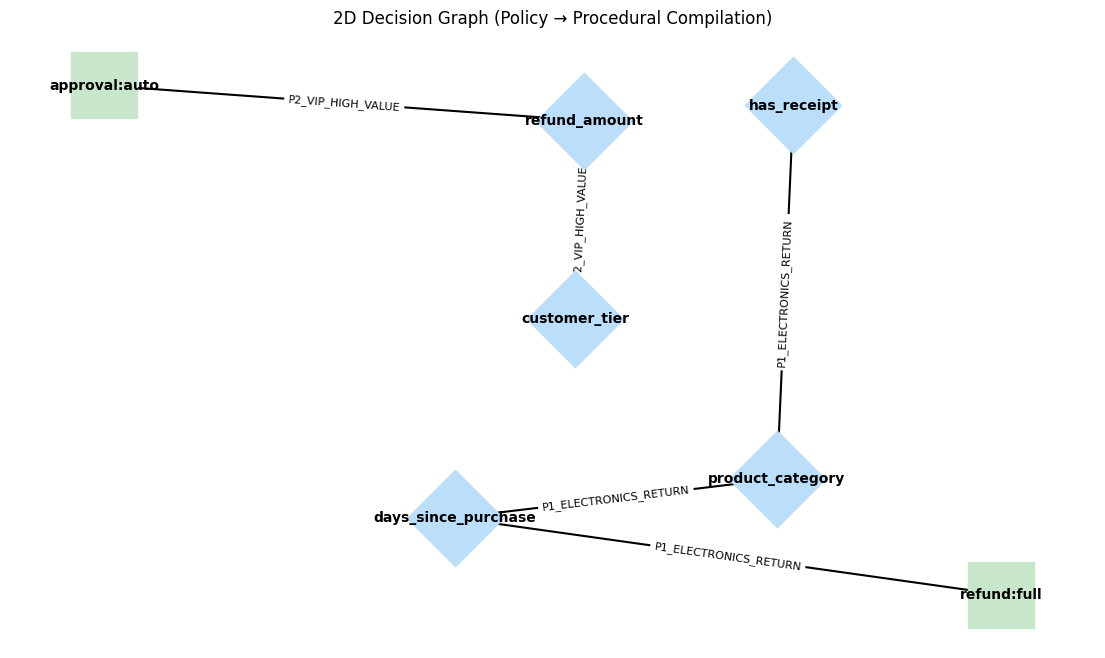

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

assert "decision_graph" in globals()

G = nx.DiGraph()

for v in decision_graph["decision_nodes"]:
    G.add_node(v, kind="decision")

for a in decision_graph["leaf_actions"]:
    G.add_node(a, kind="action")

for p in decision_graph["compiled_paths"]:
    vars_in_path = [step["var"] for step in p["path"]]
    for u, v in zip(vars_in_path[:-1], vars_in_path[1:]):
        G.add_edge(u, v, policy=p["policy_id"])
    if vars_in_path:
        G.add_edge(vars_in_path[-1], p["leaf_action"], policy=p["policy_id"])

pos = nx.spring_layout(G, seed=42, k=1.2)

decision_nodes = [n for n, d in G.nodes(data=True) if d["kind"] == "decision"]
action_nodes = [n for n, d in G.nodes(data=True) if d["kind"] == "action"]

plt.figure(figsize=(14, 8))

nx.draw_networkx_nodes(
    G, pos,
    nodelist=decision_nodes,
    node_shape="D",
    node_color="#BBDEFB",
    node_size=2400
)

nx.draw_networkx_nodes(
    G, pos,
    nodelist=action_nodes,
    node_shape="s",
    node_color="#C8E6C9",
    node_size=2200
)

nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, arrows=True, width=1.5)

edge_labels = {
    (u, v): d["policy"]
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("2D Decision Graph (Policy → Procedural Compilation)")
plt.axis("off")
plt.show()


In [ ]:
!pip install --upgrade pip
!pip install z3-solver==4.12.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 103.6 MB/s  0:00:00


In [ ]:
import json
import itertools
from typing import Dict, Any, List
from z3 import Solver, Bool, Int, Real, String, sat

assert "decision_graph" in globals()
assert "policy_ir" in globals()

paths = decision_graph["compiled_paths"]
schema = policy_ir["variables"]

def z3_var(name: str, vtype: str):
    if vtype == "bool":
        return Bool(name)
    if vtype == "int":
        return Int(name)
    if vtype == "float":
        return Real(name)
    if vtype == "enum":
        return String(name)
    raise ValueError(f"Unsupported type: {vtype}")

def encode_test(z3v, test):
    op = test["op"]
    val = test["value"]

    if isinstance(val, bool):
        val = bool(val)
    elif isinstance(val, (int, float)):
        pass
    elif isinstance(val, str):
        val = str(val)

    if op == "==":
        return z3v == val
    if op == "!=":
        return z3v != val
    if op == "<=":
        return z3v <= val
    if op == ">":
        return z3v > val

    raise ValueError(f"Unsupported operator: {op}")

def encode_path(solver: Solver, path: List[Dict], z3vars: Dict[str, Any]):
    for step in path:
        var = step["var"]
        for test in step["tests"]:
            solver.add(encode_test(z3vars[var], test))

def solve_paths(path_a: List[Dict], path_b: List[Dict]):
    solver = Solver()
    z3vars = {
        v: z3_var(v, schema[v]["type"])
        for v in schema
    }

    encode_path(solver, path_a, z3vars)
    encode_path(solver, path_b, z3vars)

    if solver.check() != sat:
        return None

    model = solver.model()
    witness = {}

    for v, z3v in z3vars.items():
        val = model.eval(z3v, model_completion=True)
        if val is None:
            continue

        vtype = schema[v]["type"]

        if vtype == "bool":
            witness[v] = bool(val)
        elif vtype == "int":
            witness[v] = val.as_long()
        elif vtype == "float":
            witness[v] = (
                float(val.numerator_as_long()) /
                float(val.denominator_as_long())
            )
        elif vtype == "enum":
            witness[v] = val.as_string()

    return witness

logical_conflicts = []

for p1, p2 in itertools.combinations(paths, 2):
    if p1["leaf_action"] == p2["leaf_action"]:
        continue

    witness = solve_paths(p1["path"], p2["path"])
    if witness is not None:
        logical_conflicts.append({
            "type": "logical",
            "policies": [p1["policy_id"], p2["policy_id"]],
            "actions": [p1["leaf_action"], p2["leaf_action"]],
            "witness": witness,
            "metadata": {
                "p1": p1["metadata"],
                "p2": p2["metadata"]
            }
        })

conflict_report = {
    "module": "2E_conflict_detection_z3",
    "logical_conflicts": logical_conflicts,
    "stats": {
        "num_policies": len(paths),
        "logical_conflicts": len(logical_conflicts)
    },
    "reproducibility": {
        "engine": "z3",
        "complete": True,
        "deterministic": True
    }
}

print("✅ 2E SMT Conflict Detection completed.\n")
print(json.dumps(conflict_report, indent=2))


✅ 2E SMT Conflict Detection completed.

{
  "module": "2E_conflict_detection_z3",
  "logical_conflicts": [
    {
      "type": "logical",
      "policies": [
        "P0_GENERAL_RETURN",
        "P2_VIP_HIGH_VALUE"
      ],
      "actions": [
        "refund:full",
        "approval:auto"
      ],
      "witness": {
        "has_receipt": true,
        "product_category": "",
        "days_since_purchase": 30,
        "refund_amount": 201.0,
        "customer_tier": "VIP"
      },
      "metadata": {
        "p1": {
          "domain": "returns",
          "priority": "company",
          "owner": "customer_support",
          "source": "returns_policy_v3",
          "eff_date": "2024-01-01"
        },
        "p2": {
          "domain": "returns",
          "priority": "company",
          "owner": "loyalty_team",
          "source": "vip_refund_guidelines",
          "eff_date": "2023-06-01"
        }
      }
    },
    {
      "type": "logical",
      "policies": [
        "P1_ELECT

In [ ]:
import json
from typing import Dict, Any, List, Tuple

assert "conflict_report" in globals()
assert "decision_graph" in globals()

PRIORITY_RANK = {
    "regulatory": 1,
    "core_values": 2,
    "company": 3,
    "department": 4,
    "situational": 5
}

pid_to_meta = {p["policy_id"]: p.get("metadata", {}) for p in decision_graph["compiled_paths"]}

def normalize_priority(meta: Dict[str, Any]) -> str:
    if meta.get("reg_link"):
        return "regulatory"
    p = (meta.get("priority") or "company").lower().strip()
    if p in PRIORITY_RANK:
        return p
    if p in {"legal", "law", "reg"}:
        return "regulatory"
    if p in {"values", "ethics", "privacy", "safety"}:
        return "core_values"
    if p in {"dept", "team"}:
        return "department"
    if p in {"promo", "temporary"}:
        return "situational"
    return "company"

def rank(meta: Dict[str, Any]) -> int:
    return PRIORITY_RANK[normalize_priority(meta)]

def owner_of(meta: Dict[str, Any]) -> str:
    return meta.get("owner", "unknown_owner")

def action_relation(a1: str, a2: str) -> str:
    if ("approval" in a1 and "refund" in a2) or ("approval" in a2 and "refund" in a1):
        return "compose"
    return "override"

def evidence_of(conf: Dict[str, Any]) -> Any:
    if "witness" in conf:
        return {"witness": conf["witness"]}
    if "witness_note" in conf:
        return {"note": conf["witness_note"]}
    if "note" in conf:
        return {"note": conf["note"]}
    return {}

auto_resolutions = []
escalations = []
dominance_rules = []
seen_rules = set()

def resolve_pair(conf: Dict[str, Any], conf_type: str):
    p1, p2 = conf["policies"]
    a1, a2 = conf["actions"]

    meta1 = conf.get("metadata", {}).get("p1") or pid_to_meta.get(p1, {})
    meta2 = conf.get("metadata", {}).get("p2") or pid_to_meta.get(p2, {})

    pr1, pr2 = rank(meta1), rank(meta2)
    rel = action_relation(a1, a2)

    if conf_type == "semantic":
        escalations.append({
            "conflict_type": "semantic",
            "policies": [p1, p2],
            "actions": [a1, a2],
            "priority": f"{normalize_priority(meta1)}|{normalize_priority(meta2)}",
            "owners_to_notify": sorted(set([owner_of(meta1), owner_of(meta2)])),
            "evidence": evidence_of(conf),
            "recommended_next_step": "llm_validation_or_human_review"
        })
        return

    if pr1 != pr2:
        winner = p1 if pr1 < pr2 else p2
        loser = p2 if winner == p1 else p1
        win_meta = meta1 if winner == p1 else meta2
        lose_meta = meta2 if winner == p1 else meta1

        auto_resolutions.append({
            "conflict_type": "logical",
            "policies": [p1, p2],
            "winner": winner,
            "loser": loser,
            "winner_priority": normalize_priority(win_meta),
            "loser_priority": normalize_priority(lose_meta),
            "action_relation": rel,
            "rationale": "priority_lattice",
            "evidence": evidence_of(conf)
        })

        key = (tuple(sorted([p1, p2])), winner, rel)
        if key not in seen_rules:
            seen_rules.add(key)
            dominance_rules.append({
                "when": {"policies_fire": sorted([p1, p2])},
                "then": {
                    "mode": "compose" if rel == "compose" else "override",
                    "enforce": winner,
                    "notes": "compose: treat approval as gating step before refund" if rel == "compose"
                             else "override: winner action replaces loser action"
                }
            })
        return

    escalations.append({
        "conflict_type": "logical",
        "policies": [p1, p2],
        "actions": [a1, a2],
        "priority": normalize_priority(meta1),
        "owners_to_notify": sorted(set([owner_of(meta1), owner_of(meta2)])),
        "evidence": evidence_of(conf),
        "recommended_next_step": "human_review"
    })

for conf in conflict_report.get("logical_conflicts", []):
    resolve_pair(conf, "logical")

for conf in conflict_report.get("semantic_conflicts", []):
    conf2 = dict(conf)
    p1, p2 = conf2["policies"]
    conf2["metadata"] = {"p1": pid_to_meta.get(p1, {}), "p2": pid_to_meta.get(p2, {})}
    resolve_pair(conf2, "semantic")

resolution_report = {
    "module": "2F_priority_resolution",
    "priority_lattice": PRIORITY_RANK,
    "auto_resolutions": auto_resolutions,
    "escalations": escalations,
    "conflict_free_plan": {
        "dominance_rules": dominance_rules,
        "notes": [
            "Logical conflicts are resolved deterministically by priority lattice.",
            "Same-priority logical conflicts are escalated to policy owners with evidence.",
            "Semantic conflicts are not auto-resolved; they require LLM validation or human review.",
            "If action_relation=compose, downstream enforcement should treat approval as a gating step for refund."
        ]
    },
    "stats": {
        "num_auto_resolutions": len(auto_resolutions),
        "num_escalations": len(escalations),
        "num_dominance_rules": len(dominance_rules)
    },
    "reproducibility": {
        "deterministic": True
    }
}

print("✅ 2F Priority Resolution completed.\n")
print(json.dumps(resolution_report, indent=2))


✅ 2F Priority Resolution completed.

{
  "module": "2F_priority_resolution",
  "priority_lattice": {
    "regulatory": 1,
    "core_values": 2,
    "company": 3,
    "department": 4,
    "situational": 5
  },
  "auto_resolutions": [],
  "escalations": [
    {
      "conflict_type": "logical",
      "policies": [
        "P0_GENERAL_RETURN",
        "P2_VIP_HIGH_VALUE"
      ],
      "actions": [
        "refund:full",
        "approval:auto"
      ],
      "priority": "company",
      "owners_to_notify": [
        "customer_support",
        "loyalty_team"
      ],
      "evidence": {
        "witness": {
          "has_receipt": true,
          "product_category": "",
          "days_since_purchase": 30,
          "refund_amount": 201.0,
          "customer_tier": "VIP"
        }
      },
      "recommended_next_step": "human_review"
    },
    {
      "conflict_type": "logical",
      "policies": [
        "P1_ELECTRONICS_RETURN",
        "P2_VIP_HIGH_VALUE"
      ],
      "actions":